# Target Detection for FMCW Radar
***

In [52]:
# Imports
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.stats as stats
import scipy

***
## Radar parameters, constants, filenames, etc.

In [2]:
sample_rate = 10e6
buffer_size = 2**14
rx_lo_freq = 2e9
tx_lo_freq = 2e9
adc_size = 2**12

c = 3e8

nc_file = 'radar_data.nc'

***
## Collect data from netCDF file

/home/bruner/miniconda3/envs/radar_tools/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


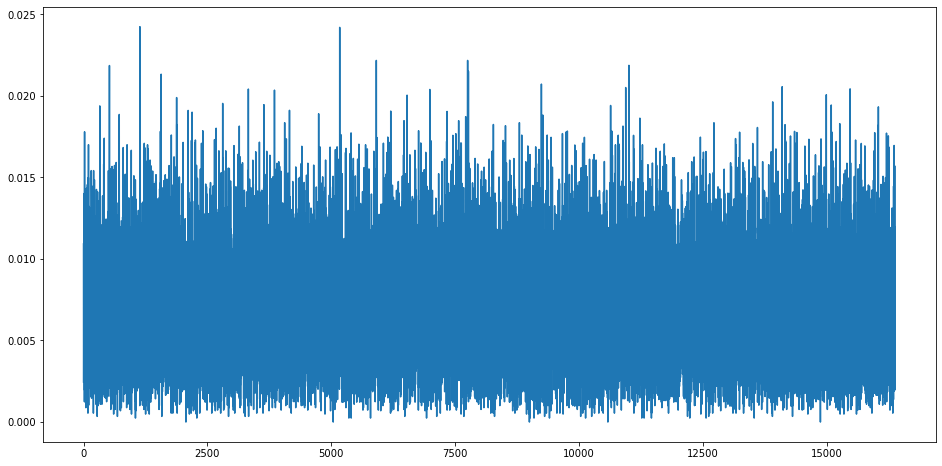

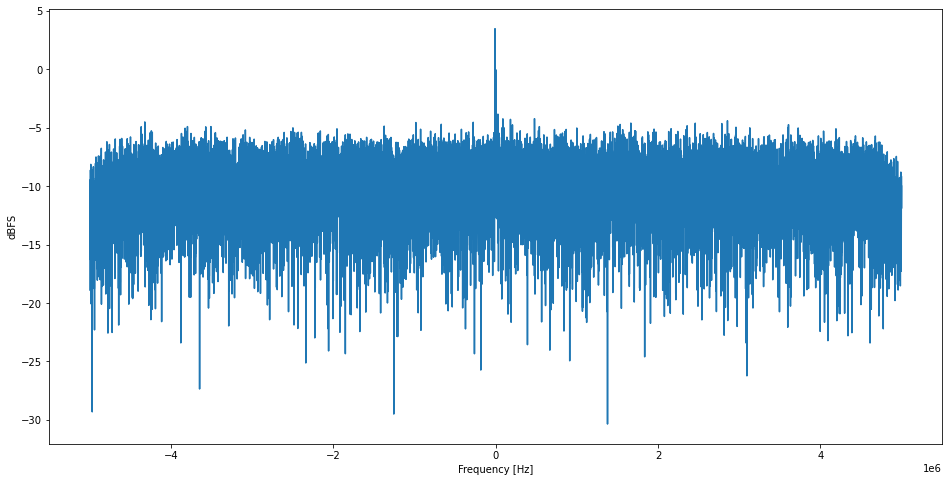

In [48]:
ds = nc.Dataset(nc_file)

i_data = ds.variables['i']
q_data = ds.variables['q']
units = i_data.units

# Take data from 1 time sample and create complex variable
iq = i_data[0,] + 1j * q_data[0,]
z = np.abs(iq)

# Plot time series
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(16)

plt.plot(z / adc_size)

# Compute DFT and plot
X_k = fft.fft(iq) / (2 * buffer_size)
X_k = fft.fftshift(X_k)
X_k_dBFS = 10 * np.log10(X_k)
freq = np.linspace(-sample_rate / 2, sample_rate / 2, buffer_size)

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(16)
plt.xlabel("Frequency [Hz]")
plt.ylabel("dBFS")

plt.plot(freq, X_k_dBFS)

***
## Noise calculation
### For coherent detectors, noise power can be estimated from the variance, $\sigma^2$,  (square of standard deviation)
$ \begin {align}
P_n &= \frac{\sigma^2}{2}
\end {align} $
<h2 style="color:red">INCOMPLETE</h2>

28.09162712097168
Mean: 28.09
Standard deviation: 14.63
Variance: 213.99
Noise power: 	107.00 bits
		-31.66 dBFS


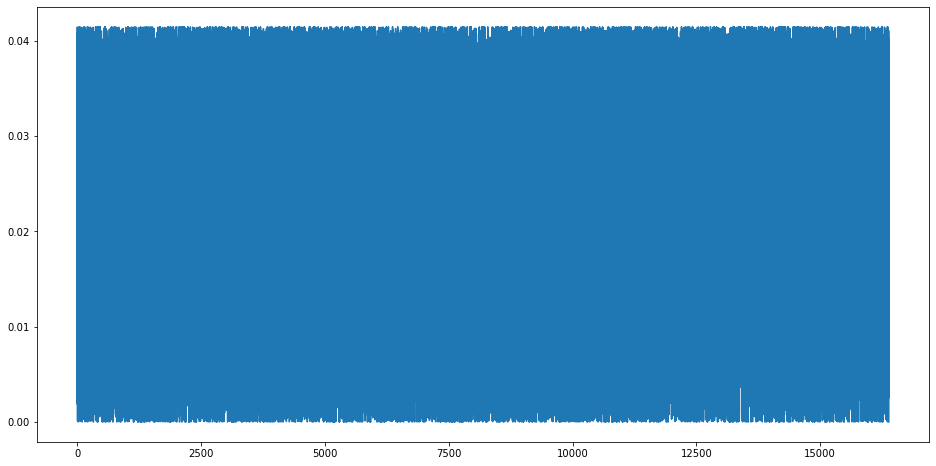

In [51]:
# Takes magnitude then caccalates standard deviation
z = np.abs(iq)
mean = np.mean(z)
print(mean)
std = np.std(z)
variance = std**2
print("Mean: %0.2f\nStandard deviation: %0.2f\nVariance: %0.2f" 
    % (mean, std, variance))

noise_power = variance / 2
noise_dBFS = 20 * np.log10(noise_power / adc_size)

print("Noise power: \t%0.2f bits\n\t\t%0.2f dBFS" %(noise_power, noise_dBFS))

pdf = (z / variance) * np.exp(-1 * z**2 / (2 * variance))
fig = plt.figure()
plt.plot(pdf)
fig.set_figwidth(16)
fig.set_figheight(8)

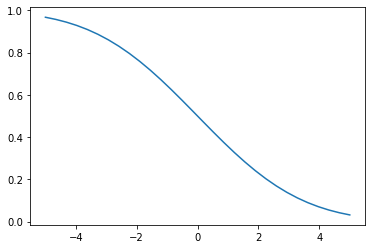

In [60]:
# Probability of false alarm
V = np.linspace(-5, 5, 30)
P_fa = 0.5 * (1 - scipy.special.erf(V / std**(0.5)))
plt.plot(V, P_fa)

In [19]:
np.sum(np.where(np.abs(iq) > adc_size))

0

***
## False alarm
### A false alarm occurs when noise jumps beyond the noise floor to a level similar to that of targets. There exists a voltage threshold, $V_T$, between a target and noise that is determined using SNR and determines the probability of false alarms, $P_{fa}$. 
$ \begin {align}
V_T &= \sqrt{-2\sigma^2 ln(P_{fa})} \\
P_d &= Q\left[\sqrt{2SNR}\sqrt{-2ln(P_{fa})}\right] \\
Q &- \text{Marcum's Q functions}
\end {align} $

***
## CFAR - Constant False Alarm Rate
### Since an incoming signal is constantly changing, the threshold, $V_T$, must also constantly update to classify parts of the signal as targets with the same false alarm rate.
### Common techniques:
#### Cell averaging - The average power is taken of all the cells surrounding the cell under test (CUT), by the following equation,
$ \begin {align}
Z &= \frac{1}{N}\sum_{n=1}^{N}X_n \\ 
N &- \text{number of range cells being averaged} \\
X_n &- \text{signal power of } n^{th} \text{cell} \\
Z &- local noise power estimate
\end {align} $
#### guard cells